<a href="https://colab.research.google.com/github/mylethidiem/AIVN_projects/blob/main/Architecture%20Project_%20Gradient%20Vanishing%20in%20MLP/2._OriginalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. Import libraries**

import các thư viện cần thiết cho việc xử lý dữ liệu, xây dựng mô hình và các công cụ hỗ trợ

In [ ]:
import random
import matplotlib.pyplot as plt # truc quan hoa
import numpy as np

import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import FashionMNIST #download fashion mnist data


Xác định phần cứng và cố định tham số ngẫu nhiên: Để đảm bảo kết quả mô hình huấn luyện được là như nhau khi bắt đầu chạy chương trình ở bất kỳ Google Colab nào, chúng ta cần cố định tham số ngẫu nhiên seed cho mọi thư viện liên quan


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

SEED = 42
set_seed(SEED)

cuda


## **1. Prepare dataset**


Bộ dữ liệu Fashion MNIST là một tập dữ liệu phổ biến, bao gồm các hình ảnh grayscale 28x28 của các loại quần áo, được sử dụng để phân loại mười nhãn khác nhau:
- 1: T-shirt/top
- 2: Trouser
- 3: Pullover
- 4: Dress
- 5: Coat
- 6: Sandal
- 7: Shirt
- 8: Sneaker
- 9: Bag
- 10: Ankle boot

Pytorch cung cấp hàm tải tự động cho bộ dữ liệu này. Chúng ta sẽ tiến hành quá trình tải và chuyển dữ liệu sang Tensor.

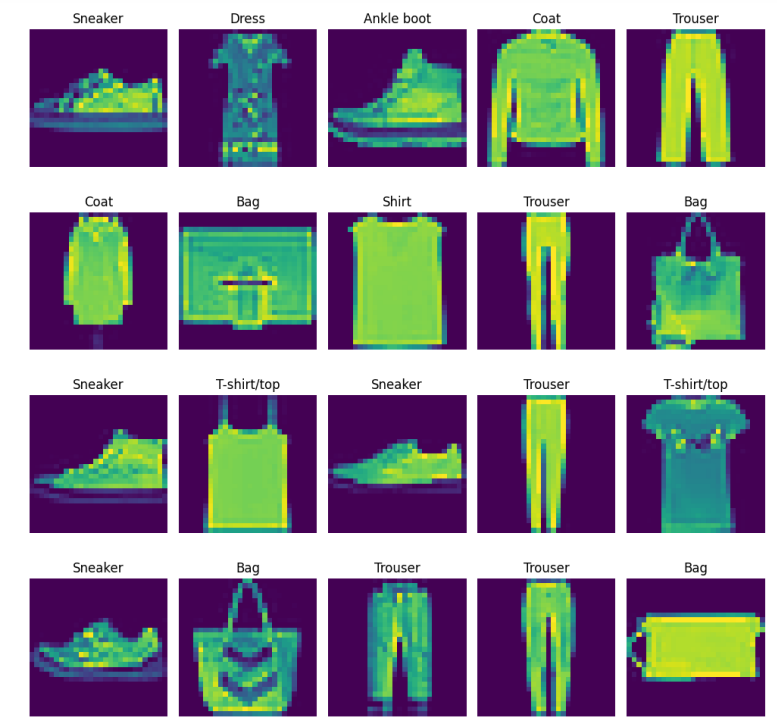

In [ ]:
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.6MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 171kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.22MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.1MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Chia bộ dữ liệu train/val/test. ta chia bộ train thành 2 phần với tỷ lệ chia là 90% cho cho train và 10% cho validation. Các tập dữ liệu này sau đó được gói vào DataLoader để dễ dàng sử dụng trong quá trình huấn luyện.

In [ ]:
train_ratio = 0.9
# train_size là số lượng mẫu dữ liệu dùng để train (54000 mẫu = 90% của tập train_dataset)
train_size = int(train_ratio * len(train_dataset)) #90%
val_size = len(train_dataset) - train_size #10%

# train_subset là tập dữ liệu con được tạo ra bằng cách chia ngẫu nhiên train_dataset thành 2 phần
# Hàm random_split() chia train_dataset thành 2 tập con:
# - train_subset: chứa train_size mẫu (54000 mẫu)
# - val_subset: chứa val_size mẫu (6000 mẫu)
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 54000
Validation size: 6000
Test size: 10000


## **2. Build MLP network**




Xây dựng mạng MLP với nhiều lớp ẩn. Mỗi lớp ẩn được nối tiếp bởi hàm kích hoạt Sigmoid. Mô hình có số lớp ẩn là 7, mỗi lớp ẩn sẽ có 128 node và hàm kích hoạt được sử dụng là hàm Sigmoid. Sau khi định nghĩa kiến trúc mạng, chúng ta sẽ khởi tạo mô hình và khai báo hàm mất mát (CrossEntropyLoss) cùng thuật toán tối ưu (SGD)

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(input_dims, hidden_dims)
    self.layer2 = nn.Linear(hidden_dims, hidden_dims)
    self.layer3 = nn.Linear(hidden_dims, hidden_dims)
    self.layer4 = nn.Linear(hidden_dims, hidden_dims)
    self.layer5 = nn.Linear(hidden_dims, hidden_dims)
    self.layer6 = nn.Linear(hidden_dims, hidden_dims)
    self.layer7 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)

  def forward(self, x):
    x = nn.Flatten()(x)
    x = self.layer1(x)
    x = nn.Sigmoid()(x)
    x = self.layer2(x)
    x = nn.Sigmoid()(x)
    x = self.layer3(x)
    x = nn.Sigmoid()(x)
    x = self.layer4(x)
    x = nn.Sigmoid()(x)
    x = self.layer5(x)
    x = nn.Sigmoid()(x)
    x = self.layer6(x)
    x = nn.Sigmoid()(x)
    x = self.layer7(x)
    x = nn.Sigmoid()(x)
    out = self.output(x)
    return out

input_dims = 784 #28x28 pixel = 784 pixel
#2^7:giá trị đủ lớn để có thể học đc các đặc trưng phức tạp, không quá lớn để bị overfitting
hidden_dims = 128
output_dims = 10 #10 class
lr = 1e-2
model = MLP(input_dims, hidden_dims, output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## **3. Training**

Huấn luyện mô hình: quá trình huấn luyện mô hình bao gồm 2 giai đoạn: train và validation.

In [ ]:
# Số lượng epochs (chu kỳ huấn luyện) cho quá trình training
# Mỗi epoch, mô hình sẽ được huấn luyện trên toàn bộ tập dữ liệu training một lần
# Với epochs = 100, mô hình sẽ được huấn luyện 100 lần trên tập dữ liệu
epochs = 100
train_loss_lst =[]
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

# Lặp qua số epochs đã định
for epoch in range(epochs):
  # Khởi tạo các biến để tính loss và accuracy cho tập train
  train_loss = 0
  train_acc = 0
  count = 0
  # Chuyển model sang chế độ train
  model.train()
  # Lặp qua từng batch dữ liệu train
  for X_train, y_train in train_loader:
    # Chuyển dữ liệu sang device (GPU/CPU)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    # Xóa gradient tích lũy từ bước trước
    optimizer.zero_grad()
    # Forward pass: tính output của model
    outputs = model(X_train)
    # Tính loss giữa output và ground truth
    loss = criterion(outputs, y_train)
    # Backward pass: tính gradient
    loss.backward()
    # Cập nhật trọng số dựa trên gradient
    optimizer.step()
    # Cộng dồn loss và accuracy
    train_loss += loss.item()
    train_acc += (torch.argmax(outputs,1) == y_train).sum().item()
    count += len(y_train)
  # Tính trung bình loss và accuracy trên tập train
  train_loss /= len(train_loader)
  train_loss_lst.append(train_loss)
  train_acc /= count
  train_acc_lst.append(train_acc)

  # Khởi tạo các biến để tính loss và accuracy cho tập validation
  val_loss = 0.0
  val_acc = 0.0
  count = 0
  # Chuyển model sang chế độ evaluation
  model.eval()
  # Tắt tính toán gradient khi validate vì:
  # 1. Không cần cập nhật trọng số trong quá trình validation
  # 2. Giúp tăng tốc độ tính toán và tiết kiệm bộ nhớ
  # 3. Đảm bảo kết quả đánh giá nhất quán vì không có sự thay đổi của trọng số
  with torch.no_grad():
    # Lặp qua từng batch dữ liệu validation
    for X_val, y_val in val_loader:
      # Chuyển dữ liệu sang device
      X_val = X_val.to(device)
      y_val = y_val.to(device)
      # Tính output
      outputs = model(X_val)
      # Tính loss
      loss = criterion(outputs, y_val)
      # Cộng dồn loss và accuracy
      val_loss += loss.item()
      val_acc += (torch.argmax(outputs,1) == y_val).sum().item()
      count += len(y_val)
  # Tính trung bình loss và accuracy trên tập validation
  val_loss /= len(val_loader)
  val_loss_lst.append(val_loss)
  val_acc /= count
  val_acc_lst.append(val_acc)

  # In kết quả sau mỗi epoch
  print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f},Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f} , Val_Acc:{val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3042,Train_Acc: 0.0996, Validation Loss: 2.3062 , Val_Acc:0.0895
EPOCH 2/100, Train_Loss: 2.3038,Train_Acc: 0.0983, Validation Loss: 2.3041 , Val_Acc:0.0895
EPOCH 3/100, Train_Loss: 2.3039,Train_Acc: 0.0962, Validation Loss: 2.3043 , Val_Acc:0.1022
EPOCH 4/100, Train_Loss: 2.3039,Train_Acc: 0.1007, Validation Loss: 2.3036 , Val_Acc:0.1022
EPOCH 5/100, Train_Loss: 2.3038,Train_Acc: 0.1009, Validation Loss: 2.3042 , Val_Acc:0.1012
EPOCH 6/100, Train_Loss: 2.3039,Train_Acc: 0.0989, Validation Loss: 2.3045 , Val_Acc:0.1000
EPOCH 7/100, Train_Loss: 2.3038,Train_Acc: 0.1006, Validation Loss: 2.3038 , Val_Acc:0.0937
EPOCH 8/100, Train_Loss: 2.3036,Train_Acc: 0.0993, Validation Loss: 2.3030 , Val_Acc:0.1018
EPOCH 9/100, Train_Loss: 2.3038,Train_Acc: 0.1000, Validation Loss: 2.3035 , Val_Acc:0.1020
EPOCH 10/100, Train_Loss: 2.3034,Train_Acc: 0.1014, Validation Loss: 2.3025 , Val_Acc:0.1097
EPOCH 11/100, Train_Loss: 2.3038,Train_Acc: 0.0987, Validation Loss: 2.3040 , V

Trực quan hóa kết quả huấn luyện: bên dưới là biểu đồ Loss và Accuracy cho cả tập train và validation

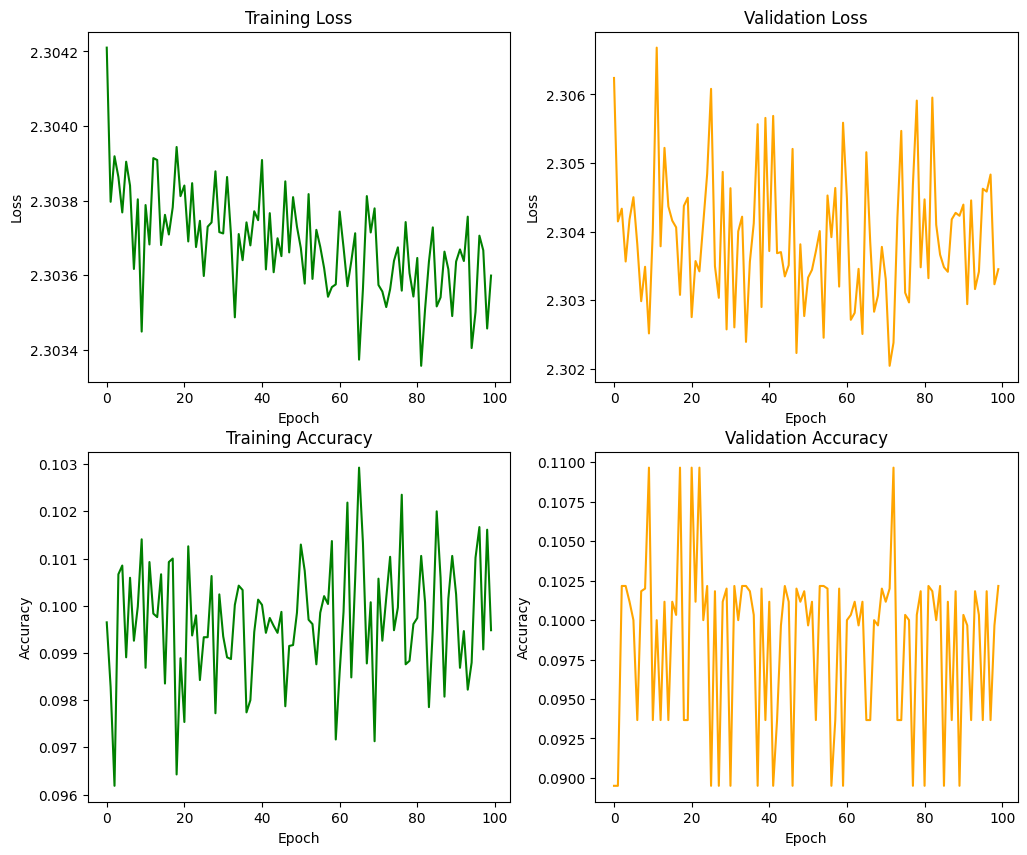

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

Trực quan hóa hiệu suất mô hình baseline trong quá trình training. Có thể thấy mô hình không thể đạt sự hội tụ tốt do vướng phải hiện tượng Vanishing Gradient

## **4. Evaluation**

Sau khi đã huấn luyện mô hình và kiểm tra trên tập validation, chúng ta cần đánh giá hiểu suất của mô hình trên tập test thông qua sử dụng dụng độ đo Accuracy để kiểm tra khả năng phân loại của mô hình trên dữ liệu chưa từng thấy

In [ ]:
# Khởi tạo list rỗng để lưu trữ nhãn thực tế của tập test
# Sau đó sẽ được sử dụng để so sánh với dự đoán của mô hình
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
  for X_test, y_test in test_loader:
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    outputs = model(X_test)

    test_target.append(y_test.cpu())
    test_predict.append(outputs.cpu())

# Ghép các batch của nhãn thực tế và dự đoán thành một tensor duy nhất
test_target = torch.cat(test_target, dim=0)
test_predict = torch.cat(test_predict, dim=0)

# Tính độ chính xác trên tập test:
# 1. torch.argmax(test_predict,1) - Lấy chỉ số của giá trị lớn nhất trên mỗi hàng (dự đoán của mô hình)
# 2. So sánh với nhãn thực tế (test_target)
# 3. Tính tổng số dự đoán đúng và chia cho tổng số mẫu
test_acc = (torch.argmax(test_predict,1)==test_target).sum().item()/len(test_target)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.1000


## **5. Methods for Improving**

Chúng ta sẽ triển khai code cài đặt các phương pháp cải tiến nhằm giảm thiểu vấn đề Vanishing gradient trong baseline model.

1. Weight inscreasing
Kỹ thuật

2. Better Activation

3. Better Optimizer

4. Normalize Inside Network

5. Skip Connection

6. Train Layers Separately

7. Gradient Normalization